In [3]:
# Nate Ramos (he/him)
# CEE 266F: PSET 4

In [4]:
# Import
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
from statsmodels.tsa.ar_model import AutoReg

In [61]:
# Define functions
def autocorr(x,k):
  '''returns the lag-k autocorrelation of vector x'''
  x = x.reshape(-1,1)
  return sm.tsa.acf(x)[1]

def thomasfiering(x, T, N):
  '''Lag-1 model. use historical data x 
  to generate N synthetic sequences of T timesteps.
  Assumes x is lognormally distributed.'''

  # Set random seed
  np.random.seed(5)

  # Log transform of data
  x = np.log(x) # log-space avoids negative values

  # Calculate mean, variance, lag-1 autocorrelation
  mu = x.mean()
  sigma = x.std()
  rho = autocorr(x,1)
  # Note the retransformation bias in rho

  # Initialize the a N x T matrix where you will save streamflow values
  Q = np.zeros([N, T])
  Q[:, 0] = np.random.normal(mu,sigma,1)  # Choose starting value

  # Loop over time, and simulate AR(1) for each
  # Note instead of looping over N, we vectorize
  for i in range(1, T):
    Z = np.random.standard_normal(N)
    Q[:, i] = mu + rho*(Q[:, i-1] - mu) + Z*sigma*np.sqrt(1-rho**2)

  return np.exp(Q)

In [6]:
# Problem 1: Apply to Folsom data
# assume annual flow data is lognormally distributed
# Load data
Q = np.loadtxt('SouthRiver_Waynesboro.csv', delimiter=',', skiprows=1, usecols=[1])

In [52]:
# Data pre-processing, conversions
Q_df = pd.read_csv('SouthRiver_Waynesboro.csv')
# if in cfs, need average?
Q_df = Q_df.fillna(method='ffill')

# convert first column to date, remove errors from 2nd
Q_df['Date'] = pd.to_datetime(Q_df['Date'],format="%Y-%m-%d")
Q_df['Flow'] = pd.to_numeric(Q_df['Flow'],errors='ignore')

# find year of each data point using .dt ; panda series
Q_df['Year'] = Q_df['Date'].dt.year
Q_df['Month'] = Q_df['Date'].dt.month

Q_array = np.array(Q_df.groupby('Year').mean()['Flow'])

#converting into 1D array
# Q_array = Q_array_conv.ravel()
years = np.unique(Q_df['Year'])

In [62]:
# Calculate frequency of multi-year droughts
# Define drought threshold as 80% of mean and length of at least 4 years
threshold = Q_array.mean() * .8
droughtLen = 4

def multi_year_drought_freq(Q, threshold, droughtLen):
  '''Count the average number of droughts that are at least as long as droughLen
    in each streamflow timeseries Q.
    Q can either be a N x T matrix or a vector with a single time series of length T'''

  # Get N and T from Q - the try except is used to handle either matrix or vector input
  try:
    T = np.shape(Q)[1]
    N = len(Q)
  except:
    N = 1
    T = len(Q)

  # If N = 1, turn vector into 2D matrix so indexing workds
  if N == 1:
    Q = Q.reshape(1, -1)

  # Initialize vector to save number of multi year droughts in each time series
  numNYrDrought = np.zeros(N)

  # Loop over each time series (could vectorize this to improve speed)
  for i in range(N):

    # Get vector for a single time series
    Q_now = Q[i,:]

    # Find which values are below the drought threshold - True means drought
    below = Q_now < threshold

    # Count the length of each consecutive set of true values (just trust me it works)
    consecTrue = np.diff(np.where(np.concatenate(([below[0]], below[:-1] != below[1:], [True])))[0])[::2]

    # Count the number of consecutive drought occurences with at least minimum length
    numNYrDrought[i] = np.sum(consecTrue >= droughtLen)

  # Average number of three year droughts over all the time series
  avgNYrDrought = np.mean(numNYrDrought)

  return avgNYrDrought, T

Means: 151.167347, 151.891605
Stdev: 60.339329, 61.834120
Rho: 0.043675, 0.067024


/Users/natram3/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
/Users/natram3/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


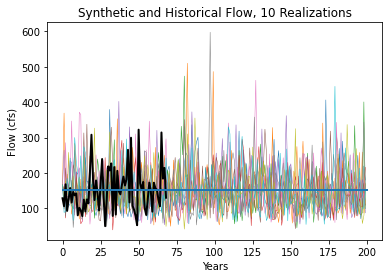

In [63]:
# 1a: First synthetic generation, statistics, and plot overlays
Q_synthetic = thomasfiering(Q_array, T=200, N=10)
print('Means: %f, %f' % (Q_array.mean(),Q_synthetic.mean()))
print('Stdev: %f, %f' % (Q_array.std(),Q_synthetic.std()))
print('Rho: %f, %f' % (autocorr(Q_array,1), autocorr(Q_synthetic,1)))

plt.set_cmap('gray')
plt.plot(np.transpose(Q_synthetic), linewidth=.5)
plt.plot(range(len(Q_by_year)),Q_by_year, color='black', linewidth=2)
plt.plot([0,200], [Q_by_year.mean(), Q_by_year.mean()], linewidth=2)
plt.xlabel('Years')
plt.ylabel('Flow (cfs)')
plt.title('Synthetic and Historical Flow, 10 Realizations')
plt.show()

In [64]:
# 1b: historical, synthetic return periods
avgNYrDrought, T = multi_year_drought_freq(Q_array.T, threshold, droughtLen)
print('A {}-year drought occured {} times in the {}-year historical record.'.format(droughtLen, avgNYrDrought, T))
print('Return period:', T/avgNYrDrought,'years.')

avgNYrDrought, T = multi_year_drought_freq(Q_synthetic, threshold, droughtLen)
print('On average, a {}-year drought occurs {} times in a {} year period, with 10 realizations'.format(droughtLen, avgNYrDrought, T))
print('Return period:', round(T/avgNYrDrought,1),'years.')

A 4-year drought occured 2.0 times in the 69-year historical record.
Return period: 34.5 years.
On average, a 4-year drought occurs 2.7 times in a 200 year period, with 10 realizations
Return period: 74.1 years.


/Users/natram3/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
/Users/natram3/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


Means: 151.167347, 151.524298
Stdev: 60.339329, 62.029198
Rho: 0.043675, 0.068502


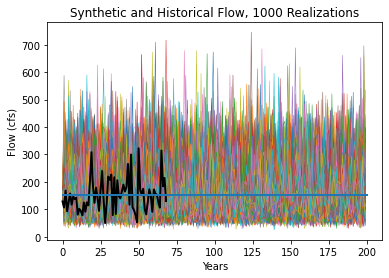

On average, a 4-year drought occurs 2.436 times in a 200 year period.
Return period: 82.1 years.
My estimated return period is greater for 1000 realizations than 10 realizations, which are both greater than the historical record.
The return period estimate on the historical record is essentially only looking at one sample.
As we generate more realizations synthetically, we have more data points available to analyze, thus reducing sampling error.
This reduces the bias we see from having too few samples, and my estimate begins to converge on the true (population) return period value with more realizations.


In [65]:
Q_synthetic_1k = thomasfiering(Q_array, T=200, N=1000)

print('Means: %f, %f' % (Q_array.mean(),Q_synthetic_1k.mean()))
print('Stdev: %f, %f' % (Q_array.std(),Q_synthetic_1k.std()))
print('Rho: %f, %f' % (autocorr(Q_array,1), autocorr(Q_synthetic_1k,1)))

plt.set_cmap('gray')
plt.plot(np.transpose(Q_synthetic_1k), linewidth=.5)
plt.plot(range(len(Q_by_year)),Q_by_year, color='black', linewidth=2)
plt.plot([0,200], [Q_by_year.mean(), Q_by_year.mean()], linewidth=2)
plt.xlabel('Years')
plt.ylabel('Flow (cfs)')
plt.title('Synthetic and Historical Flow, 1000 Realizations')
plt.show()

avgNYrDrought, T = multi_year_drought_freq(Q_synthetic_1k, threshold, droughtLen)
print('On average, a {}-year drought occurs {} times in a {} year period.'.format(droughtLen, avgNYrDrought, T))
print('Return period:', round(T/avgNYrDrought,1),'years.')
print('My estimated return period is greater for 1000 realizations than 10 realizations, which are both greater than the historical record.')
print('The return period estimate on the historical record is essentially only looking at one sample.')
print('As we generate more realizations synthetically, we have more data points available to analyze, thus reducing sampling error.')
print('This reduces the bias we see from having too few samples, and my estimate begins to converge on the true (population) return period value with more realizations.')

In [ ]:
# Problem 1d
print('Changing the seed results in return periods that generally agree to the nearest integer (70 years for N=10 and 80 years for N=1000)')
print('However, some seeds result in significantly different return periods, suggesting that more realizaitons may be necessary to ensure a greater level of convergence.')

In [22]:
# %% Problem 2
# Calculate annual daily from daily data

# Delete leap days
Q_df = Q_df[~((Q_df.Date.dt.month == 2) & (Q_df.Date.dt.day == 29))]
# no incomplete years
# Fill in a nan value
Q_df = Q_df.fillna(method='ffill')

# Get annual flow
annQ = np.array(Q_df.groupby('Year').mean()['Flow'])

/Users/natram3/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
/Users/natram3/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


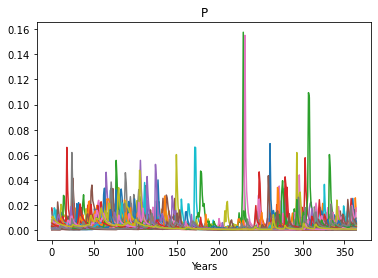

In [30]:
# 2a: Use Thomas Fiering to simulate an annual flow time series based on historical

annQsyn = thomasfiering(annQ, T=200, N=1)
annQsyn = annQsyn[0]

# Now start daily disaggretation using K-nn
#  Calculate daily proportion matrix P from historical data

# Reshape daily data into matrix
dailyQMatrix = np.array(Q_df['Flow']).reshape(-1, 365)

# Calculate annual sum i.e. sum of each row
annSum = np.sum(dailyQMatrix, 1)

# Normalize daily values by annual value
P = dailyQMatrix / annSum[:, None]

# Check that daily values sum to one
tol = .0001
assert np.sum(np.abs(np.sum(P, 1) - 1) > tol) == 0, 'rows should sum to 1'

plt.figure()
plt.plot(P.T)
plt.title('P')
plt.xlabel('Years')
plt.show()


In [24]:
#  Resample using k nearest neighbors
# Get number of years in synthetic series
N = len(annQsyn)
# Choose K as sqrt of N following Lall and Sharma 1996
k = np.int(np.sqrt(N))

# Initialize
dailyQResampled = np.zeros([N, 365])

for i in range(N):

    # For the current synthetic value, find the indicies of the
    # k nearest neighbors in the historical record
    kNN_ind = np.argsort(np.abs(annQsyn[i] - annQ))[0:k]

    # Calculate the weights and check they sum to 1
    W = [(1/i) / np.sum(1 / np.arange(1,k+1)) for i in np.arange(1,k+1)]
    assert np.round(sum(W),3) == 1.0, 'weights should sum to 1'

    # Sample a year from historical reocrd with weights W
    cumW = np.cumsum(W)
    rnd = np.random.rand()
    samp_ind = kNN_ind[np.where(rnd < cumW)[0][0]]

    # Get daily proportion series from sampled year and use to disaggregate
    # annual synthetic flow to daily flow
    dailyQResampled[i,:] = annQsyn[i] * P[samp_ind, :] * 365

<ipython-input-24-92fd0c7f5a31>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  k = np.int(np.sqrt(N))


In [33]:
Q_historical = np.empty([0,len(annQ)*365])
for i in range(len(dailyQMatrix)):
    for j in range(len(dailyQMatrix[i])):
        daily_flow_real = dailyQMatrix[i][j]
        Q_historical = np.append(Q_historical,daily_flow_real)

In [34]:
Q_synthetic1 = np.empty([0,N*365])
for i in range(len(dailyQResampled)):
    for j in range(len(dailyQResampled[i])):
        daily_flow = dailyQResampled[i][j]
        Q_synthetic1 = np.append(Q_synthetic1,daily_flow)

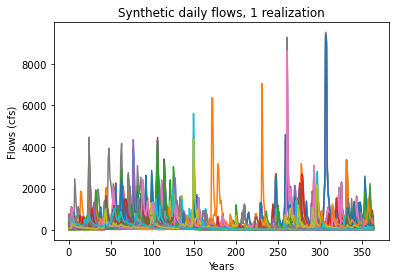

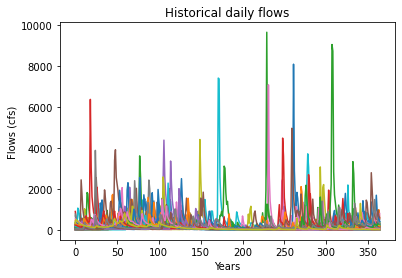

In [36]:
# Plot synthetic daily flows
plt.figure()
plt.plot(dailyQResampled.T)
plt.title('Synthetic daily flows, 1 realization')
plt.xlabel('Years')
plt.ylabel('Flows (cfs)')

plt.show()

plt.figure()
plt.plot(dailyQMatrix.T )
plt.title('Historical daily flows')
plt.xlabel('Years')
plt.ylabel('Flows (cfs)')
plt.show()

/Users/natram3/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


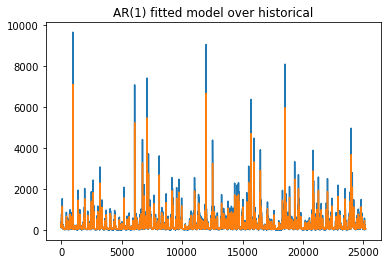

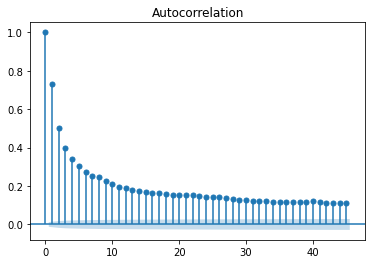

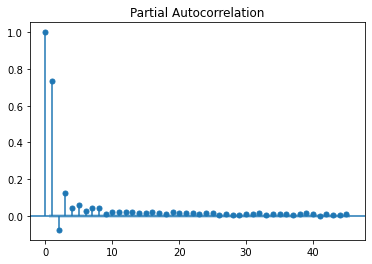

Model parameter estimates: [40.42828496  0.73250786] 
and their p-values: [2.36141147e-209 0.00000000e+000] 
Minimized AIC and BIC values: 10.392 , 10.393


In [38]:
# %% Problem 2b: historical ACF/{ACF
# test p = 1
fit = AutoReg(Q_historical, lags = [1]).fit()
fit.params # regression coefficients, phi;for each lag term
fit.pvalues # for each lag, check if stat sig
fit.aic # lower AIC better (unitless); only use relative to other models
fit.bic 

plt.plot(Q_historical[2::])
plt.plot(fit.fittedvalues)
plt.title('AR(1) fitted model over historical')
plt.show()

# %% look at acf, pacf of residuals, check if they are uncorrelated
sm.graphics.tsa.plot_acf(Q_historical)
sm.graphics.tsa.plot_pacf(Q_historical)

# input whole timeseries
plt.show()
# orange are the predicted ones, the fit using AR model

print('Model parameter estimates:',fit.params,'\nand their p-values:',fit.pvalues, '\nMinimized AIC and BIC values:',round(fit.aic,3),',',round(fit.bic,3))

/Users/natram3/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


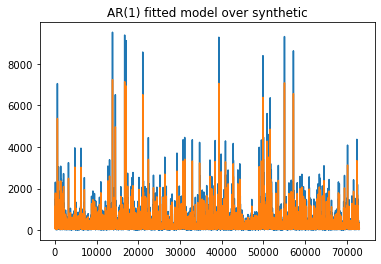

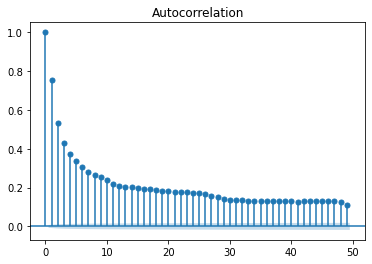

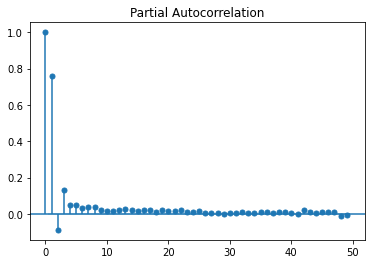

Model parameter estimates: [37.7023624   0.75652078] 
and their p-values: [0. 0.] 
Minimized AIC and BIC values: 10.268 , 10.269


In [37]:
# %% Problem 2b: synthetic ACF/PACF

# test p = 1
fit = AutoReg(Q_synthetic1, lags = [1]).fit()
fit.params # regression coefficients, phi;for each lag term
fit.pvalues # for each lag, check if stat sig
fit.aic # lower AIC better (unitless); only use relative to other models
fit.bic 

plt.plot(Q_synthetic1[2::])
plt.plot(fit.fittedvalues)
plt.title('AR(1) fitted model over synthetic')
plt.show()

# %% look at acf of residuals, check if they are uncorrelated
sm.graphics.tsa.plot_acf(Q_synthetic1)
sm.graphics.tsa.plot_pacf(Q_synthetic1)

plt.show()
# orange are the predicted ones, the fit using AR model

print('Model parameter estimates:',fit.params,'\nand their p-values:',fit.pvalues, '\nMinimized AIC and BIC values:',round(fit.aic,3),',',round(fit.bic,3))

In [66]:
# Problem 2c and 2
print('Based on the visual similarities of the two sets of ACF/PACF plots for historical and synthetic, I think we have done a good job of preserving seasonality and autocorrelation.')
print('This is because the k-NN method essentially scales a year of historical data similar to one I sampled. Thus, the overall shape of the distiribution remains similar, while all the values are adjusted (up/down).')

print('\nNo, an AR(1) model applied directly to the daily flows would not capture daily autocorrelation. Daily autocorrelation often lasts multiple lags, as precipitation events can last multiple days. We would need to use an AR model with more lags for daily data.')


Based on the visual similarities of the two sets of ACF/PACF plots for historical and synthetic, I think we have done a good job of preserving seasonality and autocorrelation.
This is because the k-NN method essentially scales a year of historical data similar to one I sampled. Thus, the overall shape of the distiribution remains similar, while all the values are adjusted (up/down).

No, an AR(1) model applied directly to the daily flows would not capture daily autocorrelation. Daily autocorrelation often lasts multiple lags, as precipitation events can last multiple days. We would need to use an AR model with more lags for daily data.
